In [2216]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Importo librería statsmodel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model

In [2217]:
# Libraries to connect with SQL
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

In [2218]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/house_price_data'
engine = create_engine(connection_string)

In [2219]:
# Load data
df = pd.read_excel ('regression_data.xls')

In [2220]:
df_sql = df

In [2221]:
# Rename view and condition
df_sql.rename(columns={'view': 'house_view', 'condition': 'house_condition'}, inplace=True)

In [2223]:
df_sql.to_sql('house_price_data', engine, if_exists='append', index=False)

OperationalError: (pymysql.err.OperationalError) (1049, "Unknown database 'house_price_data'")
(Background on this error at: https://sqlalche.me/e/14/e3q8)

# Data Preprocessing

- In the data preprocessing phase, we first examined the shape of the data to understand its dimensiones.
- Next, we checked for null values in the dataset.

In [ ]:
df.shape

(21597, 21)

In [ ]:
# Checking for null values
nulls = pd.DataFrame(df.isna().sum()/len(df))
nulls= nulls.reset_index()
nulls.columns = ['column_name', 'Percentage Null Values']
nulls.sort_values(by='Percentage Null Values', ascending = False)

,column_name,Percentage Null Values
0,id,0.0
11,sqft_above,0.0
19,sqft_lot15,0.0
18,sqft_living15,0.0
17,long,0.0
16,lat,0.0
15,zipcode,0.0
14,yr_renovated,0.0
13,yr_built,0.0
12,sqft_basement,0.0


In [ ]:
# Partial dataframe visualization
df.head ()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [ ]:
df.shape

(21597, 21)

In [ ]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [ ]:
# Stats info
df.describe ()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


In [ ]:
# Rename columns
df = df.rename(columns=lambda x: x.upper().replace(' ', '_'))

In [ ]:
df.columns

Index(['ID', 'DATE', 'BEDROOMS', 'BATHROOMS', 'SQFT_LIVING', 'SQFT_LOT',
       'FLOORS', 'WATERFRONT', 'VIEW', 'CONDITION', 'GRADE', 'SQFT_ABOVE',
       'SQFT_BASEMENT', 'YR_BUILT', 'YR_RENOVATED', 'ZIPCODE', 'LAT', 'LONG',
       'SQFT_LIVING15', 'SQFT_LOT15', 'PRICE'],
      dtype='object')

In [ ]:
# Duplicated IDs
duplicate_ids = df['ID'].duplicated()

# Duplicate rows
duplicated_rows = df[duplicate_ids]

# Count duplicates
num_duplicates = duplicate_ids.sum()

print("Total number of duplicates:", num_duplicates)

Total number of duplicates: 177


In [ ]:
df.drop_duplicates(subset = ['ID'])

,ID,DATE,BEDROOMS,BATHROOMS,SQFT_LIVING,SQFT_LOT,FLOORS,WATERFRONT,VIEW,CONDITION,...,SQFT_ABOVE,SQFT_BASEMENT,YR_BUILT,YR_RENOVATED,ZIPCODE,LAT,LONG,SQFT_LIVING15,SQFT_LOT15,PRICE
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


In [ ]:
df.shape

(21597, 21)

ID: Identification variable
DATE: I'll see if it has any relation to the price of housing. In case of not obtaining a significant result, I will ignore it for the analysis of the case.

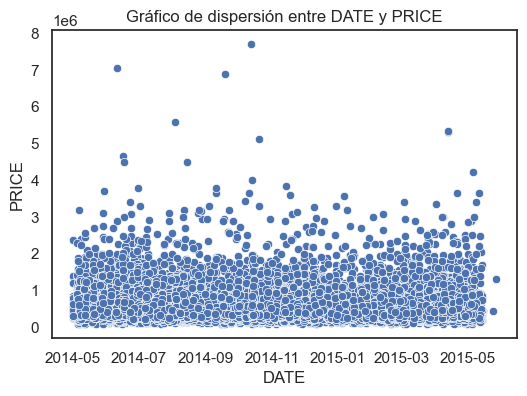

In [ ]:
# Variable DATE
plt.figure(figsize=(6, 4))
sns.scatterplot(x='DATE', y='PRICE', data=df)
plt.title('Gráfico de dispersión entre DATE y PRICE')
plt.xlabel('DATE')
plt.ylabel('PRICE')
plt.show()

Considering this information, I will dismiss the DATE variable for the analysis of the case.

In [ ]:
# I see what variables I could consider as categorical

for columna in df.columns:
    # Get the unique values ​​of the current column
    unique_values = df[columna].unique()
    if len(unique_values) < 20:
        print (columna,': ', unique_values)

BEDROOMS :  [ 3  2  4  5  1  6  7  8  9 11 10 33]
FLOORS :  [1.  2.  1.5 3.  2.5 3.5]
WATERFRONT :  [0 1]
VIEW :  [0 3 4 2 1]
CONDITION :  [3 5 4 1 2]
GRADE :  [ 7  6  8 11  9  5 10 12  4  3 13]


I will remove the LAT and LONG columns

In [ ]:
df = df.drop('LAT', axis = 1)

In [ ]:
df = df.drop('LONG', axis = 1)

I will treat the variables (4) WATERFRONT AND ZIPCODE as categorical.


Var. Identification (1): ID

Var. to ignore (1): DATE

Var. numerical (15): 'BEDROOMS', 'BATHROOMS', 'SQFT_LIVING', 'SQFT_LOT','FLOORS','VIEW', 'CONDITION', 'GRADE', 'SQFT_ABOVE', 'SQFT_BASEMENT', 'YR_BUILT', 'YR_RENOVATED','SQFT_LIVING15', 'SQFT_LOT15', 'PRICE'

Var. categorical (4): ['WATERFRONT','ZIPCODE']

# Exploratory Data Analysis

### Numerical

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,21597.0,4.580474e+09,2.876736e+09,1000102.0,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
BEDROOMS,21597.0,3.373200e+00,9.262989e-01,1.0,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
BATHROOMS,21597.0,2.115826e+00,7.689843e-01,0.5,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
SQFT_LIVING,21597.0,2.080322e+03,9.181061e+02,370.0,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
SQFT_LOT,21597.0,1.509941e+04,4.141264e+04,520.0,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
FLOORS,21597.0,1.494096e+00,5.396828e-01,1.0,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
WATERFRONT,21597.0,7.547345e-03,8.654900e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
VIEW,21597.0,2.342918e-01,7.663898e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
CONDITION,21597.0,3.409825e+00,6.505456e-01,1.0,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
GRADE,21597.0,7.657915e+00,1.173200e+00,3.0,7.000000e+00,7.000000e+00,8.000000e+00,1.300000e+01


OUTLIERS

I will see what type of statistical contribution each of the numerical variables provides. I'll start with the discrete variables.

In [ ]:
df.BEDROOMS.unique ()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [ ]:
# I see the percentage of each value in the total. 
df['BEDROOMS'].value_counts()/df['BEDROOMS'].count ()*100

3     45.487799
4     31.865537
2     12.779553
5      7.413067
6      1.259434
1      0.907533
7      0.175950
8      0.060194
9      0.027782
10     0.013891
11     0.004630
33     0.004630
Name: BEDROOMS, dtype: float64

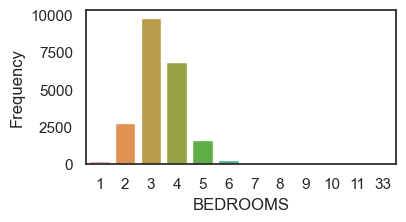

In [ ]:
#BEDROOMS
sns.set(style="white")
plt.figure(figsize=(4, 2))
sns.countplot(x='BEDROOMS', data=df)
plt.ylabel('Frequency', fontsize=12)
plt.show()

I add the data proportions of the houses that have between 1 and 6 rooms.

In [ ]:
45.489906 + 31.867012 + 12.780144 + 7.413410 + 1.259492 + 0.907575

99.71753899999997

They represent 99.71% of the data so I will only consider this information. Deleting the rest of the rows.

In [ ]:
# I remove the outlier that has value 33.
df = df[~df['BEDROOMS'].isin([7,8,9,10,11,33])]

In [ ]:
# Checking Bedrooms unique values
df.BEDROOMS.unique ()

array([3, 2, 4, 5, 1, 6])

In [ ]:
# Create dataframe with categorical variables
df_cat = df.loc[:, ['WATERFRONT','ZIPCODE']]
df_cat.shape

(21535, 2)

In [ ]:
# Create dataframe with numerical variables
df_num = df.loc[:, ['BEDROOMS', 'BATHROOMS', 'SQFT_LIVING', 'SQFT_LOT',
       'FLOORS','VIEW', 'CONDITION', 'GRADE', 'SQFT_ABOVE',
       'SQFT_BASEMENT', 'YR_BUILT', 'YR_RENOVATED',
       'SQFT_LIVING15', 'SQFT_LOT15', 'PRICE']]
df_num.shape

(21535, 15)

Data Visualization

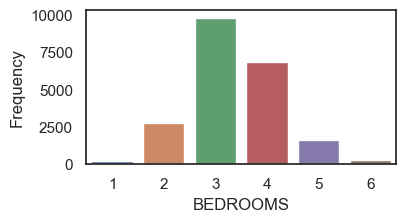

In [ ]:
# BEDROOMS
sns.set(style="white")
plt.figure(figsize=(4, 2))
sns.countplot(x='BEDROOMS', data=df_num)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [ ]:
# BATHROOMS
df_num.BATHROOMS.min (),df_num.BATHROOMS.max ()

(0.5, 8.0)

In [ ]:
# I'll group the values ​​by ranges: 1-1.5, 2-2.5, 3-3.5. By doing this I reduce the categories of analysis while keeping the information relevant.
df_num['BATHROOMS'].replace(to_replace = [1.25, 1.75, 2.25, 2.75,3.25, 3.75,4.25, 4.75,5.25, 5.75,6.25, 6.75,7.25,7.75], 
value = [1, 1.5, 2, 2.5,3, 3.5,4, 4.5,5, 5.5,6, 6.5,7,7.5], inplace=True)

In [ ]:
df_num.BATHROOMS.min (), df_num.BATHROOMS.max ()

(0.5, 8.0)

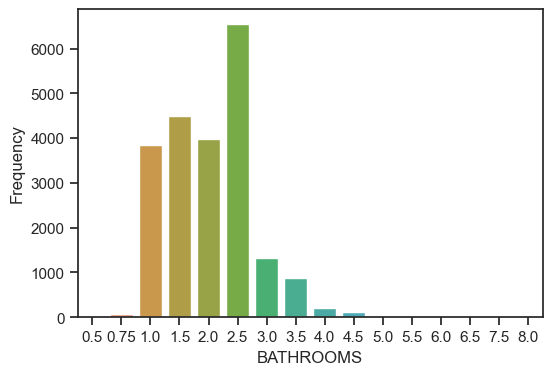

In [ ]:
# BATHROOMS DISTRIBUTION
sns.set(style = "ticks")
plt.figure(figsize=(6, 4))
sns.countplot(x='BATHROOMS', data = df_num)
plt.ylabel('Frequency', fontsize=12)
plt.show()

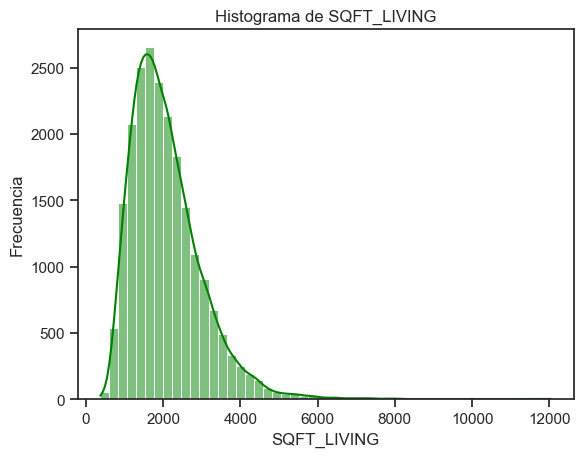

In [ ]:
# Variable SQFT_LIVING

plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['SQFT_LIVING'], bins = 50, kde = True, color = 'green')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de SQFT_LIVING')
plt.xlabel('SQFT_LIVING')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
df_num.SQFT_LOT.describe ()

count    2.153500e+04
mean     1.509742e+04
std      4.142101e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.615000e+03
75%      1.066750e+04
max      1.651359e+06
Name: SQFT_LOT, dtype: float64

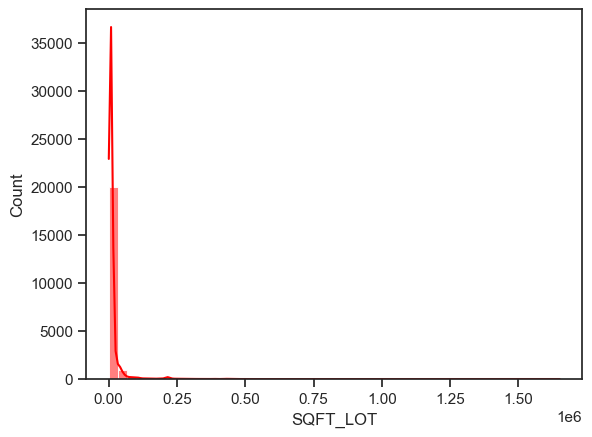

In [ ]:
# Variable SQFT_LOT
sns.histplot(df_num['SQFT_LOT'], bins = 50, kde = True, color = 'red')  # Crea un histograma para la columna
plt.show()

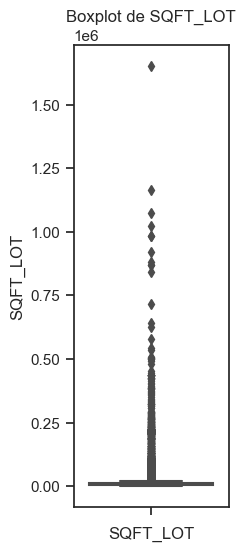

In [ ]:
plt.figure(figsize=(2, 6))
sns.boxplot(y=df_num['SQFT_LOT'])
plt.xlabel('SQFT_LOT')
plt.title('Boxplot de SQFT_LOT')
plt.show()

Data in the SQFT_LOT column is highly skewed (positive skewness).
Removing outliers straight away might not be the best idea as it would remove a lot of data points from the data.
We will try some transformations.

In [ ]:
def log_transfom_clean_(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN # We are returning NaNs so that we can replace them later

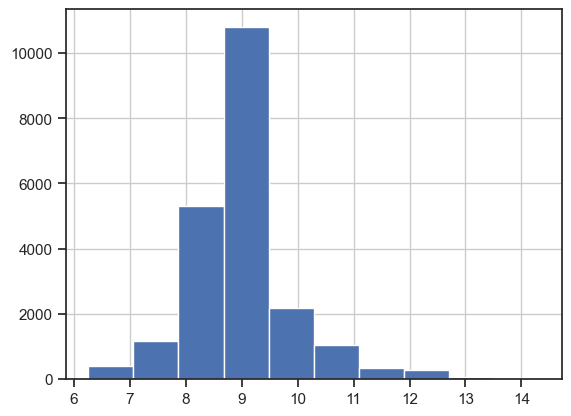

In [ ]:
# Using the functions to check the distribution of transformed data
pd.Series(map(log_transfom_clean_, df_num['SQFT_LOT'])).hist()
plt.show()

/var/folders/23/k5r960jx4j5_kg5518sbq1hc0000gp/T/ipykernel_55416/3308177109.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_num['SQFT_LOT'])


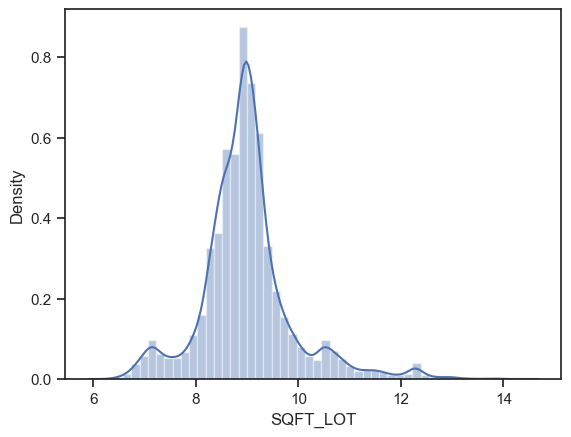

In [ ]:
# Use log transformation to replace the values of the column now
df_num['SQFT_LOT'] = list(map(log_transfom_clean_, df_num['SQFT_LOT']))
df_num['SQFT_LOT'] = df_num['SQFT_LOT'].fillna(np.mean(df_num['SQFT_LOT']))
sns.distplot(df_num['SQFT_LOT'])
plt.show()

In [ ]:
df_num.SQFT_LOT.describe ()

count    21535.000000
mean         8.989414
std          0.902334
min          6.253829
25%          8.525161
50%          8.937875
75%          9.274957
max         14.317109
Name: SQFT_LOT, dtype: float64

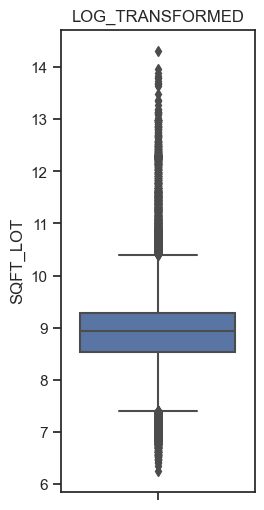

In [ ]:
plt.figure(figsize=(2.5, 6))
sns.boxplot(y = df_num['SQFT_LOT'])
plt.title('LOG_TRANSFORMED')
plt.show()

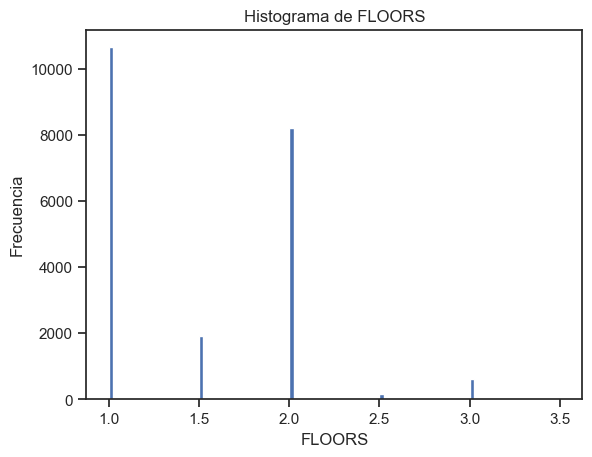

In [ ]:
fig = plt.figsize =(3, 3)

plt.hist(df_num['FLOORS'], bins=100)

# Agrega títulos y etiquetas a los ejes
plt.title("Histograma de FLOORS")
plt.xlabel('FLOORS')
plt.ylabel("Frecuencia")

plt.show ()

In [ ]:
df_num.FLOORS.describe ()

count    21535.000000
mean         1.493360
std          0.539494
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: FLOORS, dtype: float64

In [ ]:
df_num.FLOORS.unique ()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [ ]:
# Agruparé los valores por rangos: 1-1.5, 2-2.5, 3-3.5. Haciendo esto reduzco las categorías de analisis mientras mantengo la información relevante.
df_num['FLOORS'].replace(to_replace = [1.5, 2.5, 3.5], value = [1, 2, 3], inplace=True)

In [ ]:
df_num.FLOORS.unique ()

array([1., 2., 3.])

In [ ]:
df_num.FLOORS.unique ()

array([1., 2., 3.])

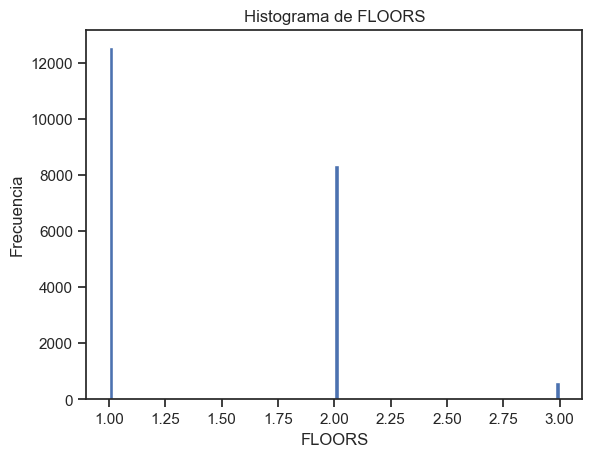

In [ ]:
fig = plt.figsize =(3, 3)

plt.hist(df_num['FLOORS'], bins=100)

# Agrega títulos y etiquetas a los ejes
plt.title("Histograma de FLOORS")
plt.xlabel('FLOORS')
plt.ylabel("Frecuencia")

plt.show ()

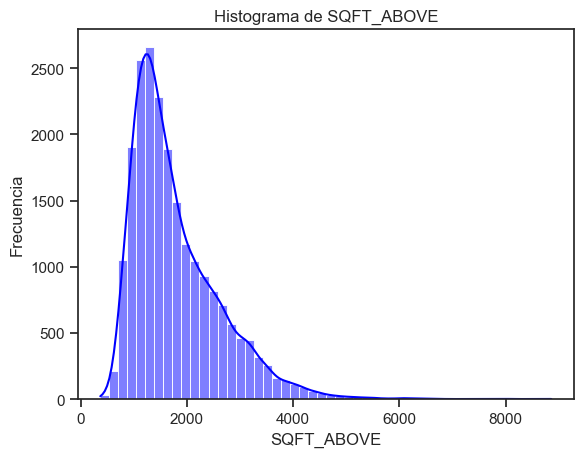

In [ ]:
# Variable SQFT_ABOVE

plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['SQFT_ABOVE'], bins = 50, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de SQFT_ABOVE')
plt.xlabel('SQFT_ABOVE')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
df_num['SQFT_ABOVE'].describe ()

count    21535.000000
mean      1785.243836
std        823.245932
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       8860.000000
Name: SQFT_ABOVE, dtype: float64

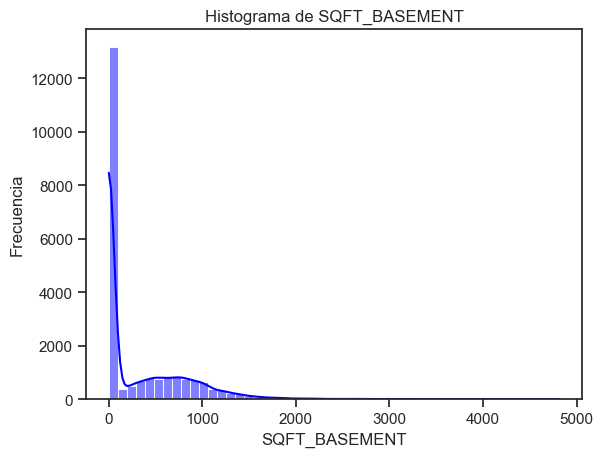

In [ ]:
# Variable SQFT_BASEMENT: Superficie del sótano.

plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['SQFT_BASEMENT'], bins = 50, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de SQFT_BASEMENT')
plt.xlabel('SQFT_BASEMENT')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
df_num.SQFT_BASEMENT.describe ()

count    21535.000000
mean       289.977943
std        439.976823
min          0.000000
25%          0.000000
50%          0.000000
75%        560.000000
max       4820.000000
Name: SQFT_BASEMENT, dtype: float64

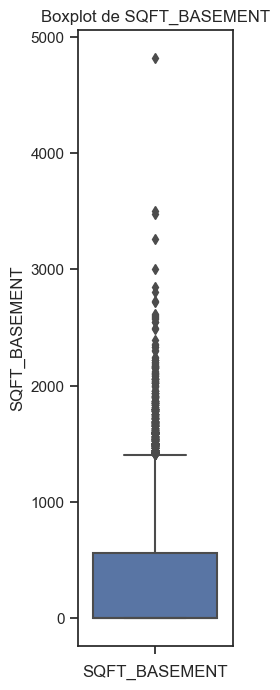

In [ ]:
plt.figure(figsize=(2, 8))
sns.boxplot(y=df_num['SQFT_BASEMENT'])

# plt.boxplot(df_num['SQFT_BASEMENT'], vert=True)
plt.xlabel('SQFT_BASEMENT')
plt.title('Boxplot de SQFT_BASEMENT')
plt.show()

Podemos observar que una gran cantidad de propiedades no tiene sótano, y las propiedades que si tienen, tienen un área grande, lo que genera una dispersión en los datos que corregiré para poder analizarlo homogéneamente.

/var/folders/23/k5r960jx4j5_kg5518sbq1hc0000gp/T/ipykernel_55416/2806077809.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_num['SQFT_BASEMENT'])


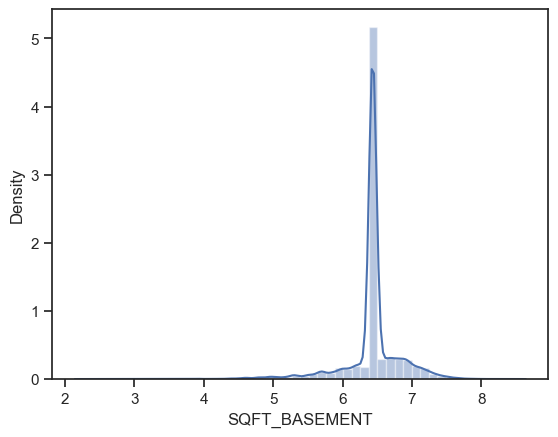

In [ ]:
# Use log transformation to replace the values of the column now
df_num['SQFT_BASEMENT'] = list(map(log_transfom_clean_, df_num['SQFT_BASEMENT']))
df_num['SQFT_BASEMENT'] = df_num['SQFT_BASEMENT'].fillna(np.mean(df_num['SQFT_BASEMENT']))
sns.distplot(df_num['SQFT_BASEMENT'])
plt.show()

In [ ]:
df_num['SQFT_BASEMENT'].describe ()

count    21535.000000
mean         6.435920
std          0.398198
min          2.302585
25%          6.435920
50%          6.435920
75%          6.435920
max          8.480529
Name: SQFT_BASEMENT, dtype: float64

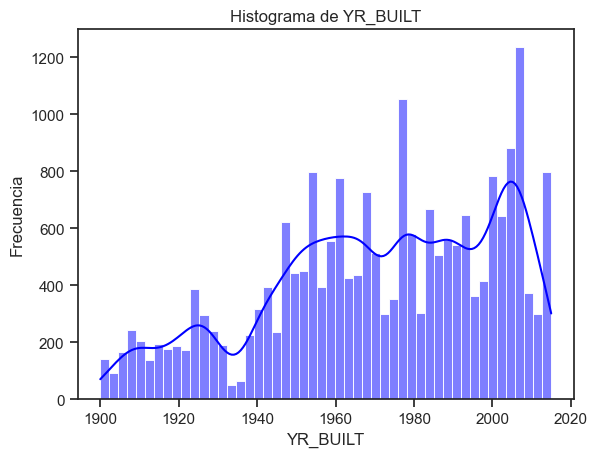

In [ ]:
# Variable YR_BUILT

plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['YR_BUILT'], bins = 50, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de YR_BUILT')
plt.xlabel('YR_BUILT')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
df_num.YR_BUILT.describe ()

count    21535.000000
mean      1971.039053
std         29.359903
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: YR_BUILT, dtype: float64

In [ ]:
# Variable YR_RENOVATED
df_num['YR_RENOVATED'].describe ()

count    21535.000000
mean        84.150081
std        401.100740
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: YR_RENOVATED, dtype: float64

Veo cuantos valores son mayores que 0 y en base a eso consideraré o no la variable para el caso.

In [ ]:
(df_num['YR_RENOVATED'] > 0).sum(), (df_num['YR_RENOVATED'] > 0).sum()/df_num['YR_RENOVATED'].count ()*100

(908, 4.216391920130021)

Mas del 4% de los datos me resulta considerable así que no eliminaré la columna.

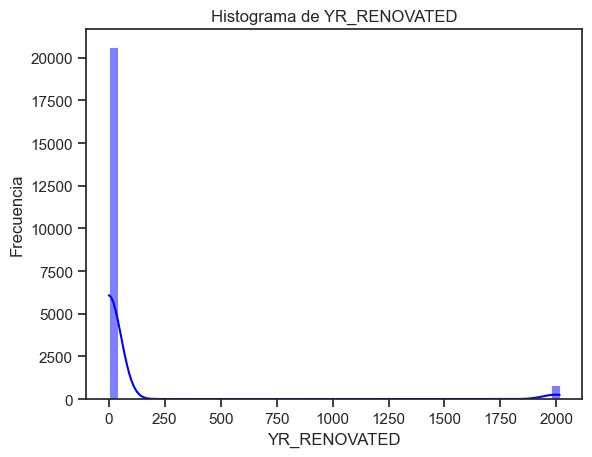

In [ ]:
plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['YR_RENOVATED'], bins = 50, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de YR_RENOVATED')
plt.xlabel('YR_RENOVATED')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
(df_num['YR_RENOVATED'] > 2000).sum()

419

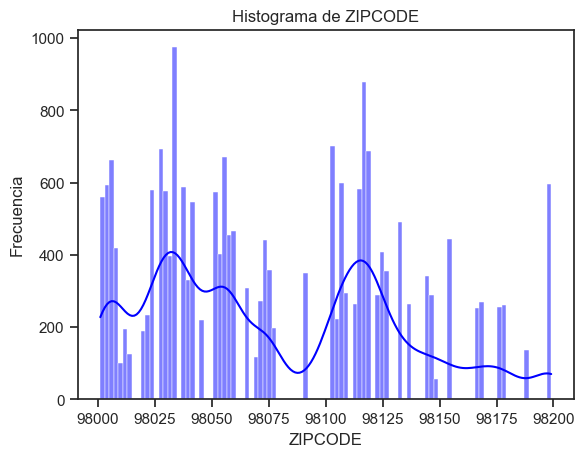

In [ ]:
plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_cat['ZIPCODE'], bins = 100, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de ZIPCODE')
plt.xlabel('ZIPCODE')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

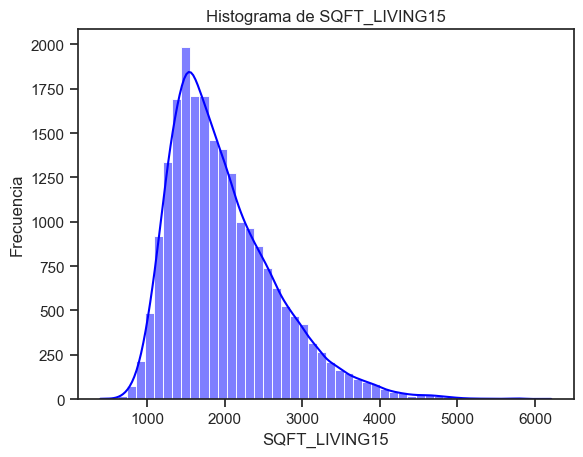

In [ ]:
# Variable SQFT_LIVING15
plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['SQFT_LIVING15'], bins = 50, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de SQFT_LIVING15')
plt.xlabel('SQFT_LIVING15')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
df_num.SQFT_LIVING15.describe ()

count    21535.000000
mean      1985.835663
std        684.596314
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: SQFT_LIVING15, dtype: float64

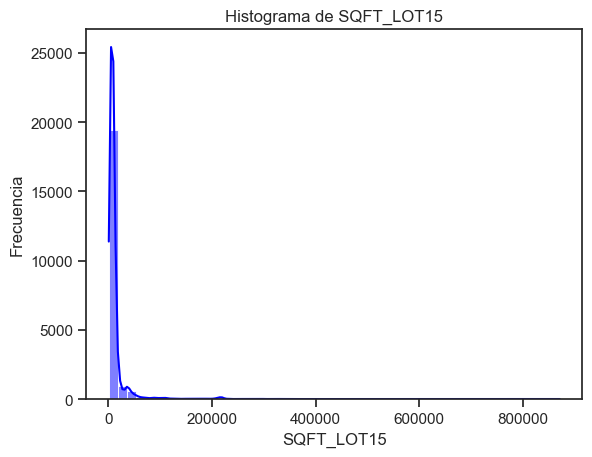

In [ ]:
# Variable SQFT_LOT15: LotSize area in 2015(implies - some renovations).

plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['SQFT_LOT15'], bins = 50, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de SQFT_LOT15')
plt.xlabel('SQFT_LOT15')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
df_num.SQFT_LOT15.describe ()

count     21535.000000
mean      12759.793220
std       27274.117437
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10081.500000
max      871200.000000
Name: SQFT_LOT15, dtype: float64

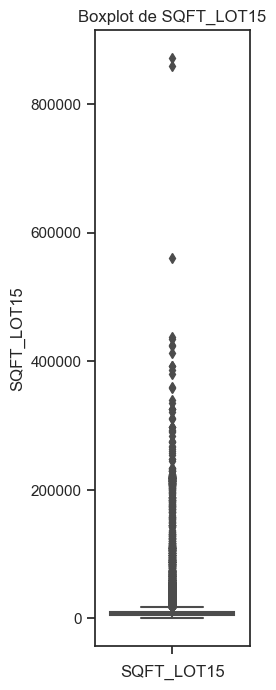

In [ ]:
plt.figure(figsize=(2, 8))
sns.boxplot(y=df_num['SQFT_LOT15'])

# plt.boxplot(df_num['SQFT_LOT15'], vert=True)
plt.xlabel('SQFT_LOT15')
plt.title('Boxplot de SQFT_LOT15')
plt.show()

/var/folders/23/k5r960jx4j5_kg5518sbq1hc0000gp/T/ipykernel_55416/2908863082.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_num['SQFT_LOT15'])


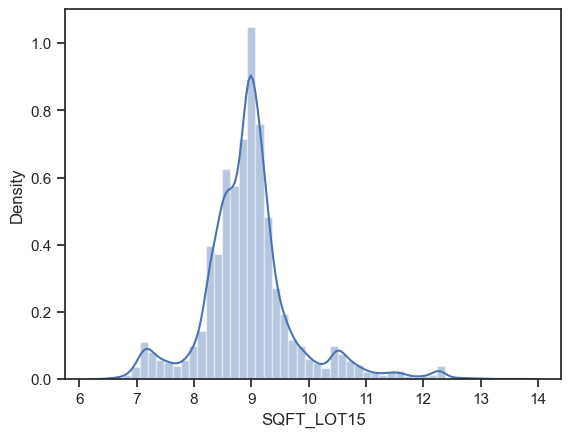

In [ ]:
# Use log transformation to replace the values of the column now
df_num['SQFT_LOT15'] = list(map(log_transfom_clean_, df_num['SQFT_LOT15']))
df_num['SQFT_LOT15'] = df_num['SQFT_LOT15'].fillna(np.mean(df_num['SQFT_LOT15']))
sns.distplot(df_num['SQFT_LOT15'])
plt.show()

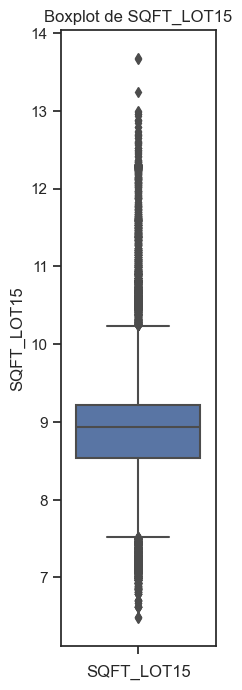

In [ ]:
plt.figure(figsize=(2, 8))
sns.boxplot(y=df_num['SQFT_LOT15'])

# plt.boxplot(df_num['SQFT_LOT15'], vert=True)
plt.xlabel('SQFT_LOT15')
plt.title('Boxplot de SQFT_LOT15')
plt.show()

In [ ]:
df_num['SQFT_LOT15'].describe ()

count    21535.000000
mean         8.960932
std          0.812652
min          6.478510
25%          8.536996
50%          8.938532
75%          9.218457
max         13.677627
Name: SQFT_LOT15, dtype: float64

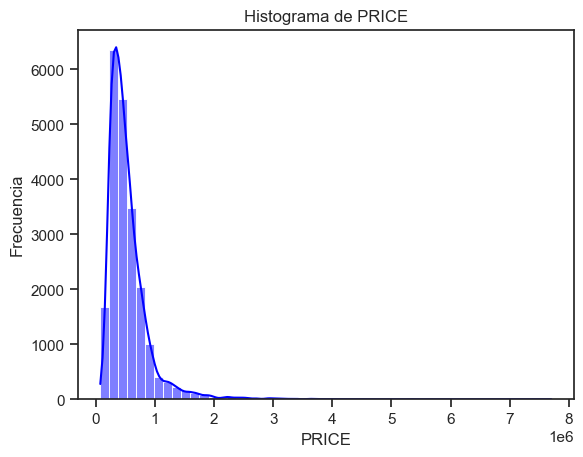

In [ ]:
# Variable PRICE

plt.figure()  # Crea una nueva figura para cada gráfico
sns.histplot(df_num['PRICE'], bins = 50, kde = True, color = 'blue')  # Crea un histograma para la columna
    
# Agrega títulos y etiquetas a los ejes
plt.title('Histograma de PRICE')
plt.xlabel('PRICE')
plt.ylabel("Frecuencia")
    
plt.show()  # Muestra el gráfico

In [ ]:
df_num.PRICE.describe ()

count    2.153500e+04
mean     5.390889e+05
std      3.652086e+05
min      7.800000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.430000e+05
max      7.700000e+06
Name: PRICE, dtype: float64

In [ ]:
df_num.columns

Index(['BEDROOMS', 'BATHROOMS', 'SQFT_LIVING', 'SQFT_LOT', 'FLOORS', 'VIEW',
       'CONDITION', 'GRADE', 'SQFT_ABOVE', 'SQFT_BASEMENT', 'YR_BUILT',
       'YR_RENOVATED', 'SQFT_LIVING15', 'SQFT_LOT15', 'PRICE'],
      dtype='object')

In [ ]:
df_cat.columns

Index(['WATERFRONT', 'ZIPCODE'], dtype='object')

Analizaré la variable WATERFRONT para determinar si la considero para el análisis.

In [ ]:
# Cuento WATERFRONT = 1
(df_cat['WATERFRONT']>0).sum()

163

In [ ]:
# Veo cuanto representa en mi DF.
((df_cat['WATERFRONT']>0).sum()/df_cat['WATERFRONT'].count ()) * 100

0.7569073601114464

Representa menos del 1% de los datos, así que la eliminaré.

Variable VIEW

In [ ]:
df_num['VIEW'].unique ()

array([0, 3, 4, 2, 1])

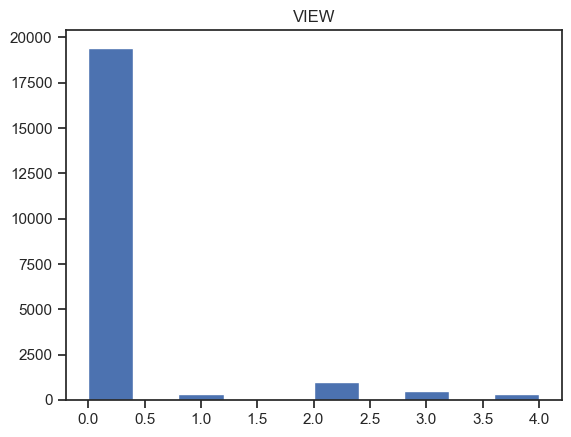

In [ ]:
plt.hist(df_num['VIEW'])
plt.title('VIEW')
plt.show()

Variable Condition

In [ ]:
df_num.CONDITION.unique ()

array([3, 5, 4, 1, 2])

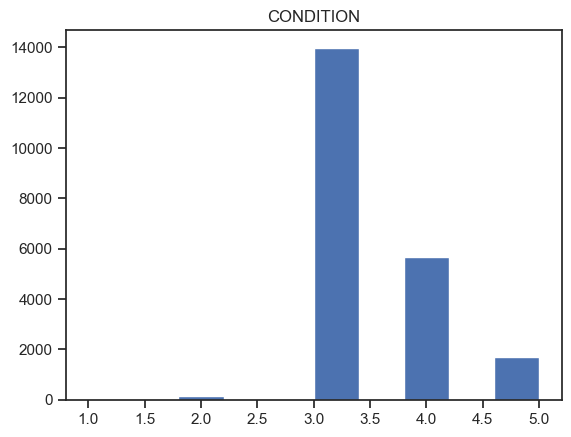

In [ ]:
plt.hist(df_num['CONDITION'])
plt.title('CONDITION')
plt.show()

Variable GRADE

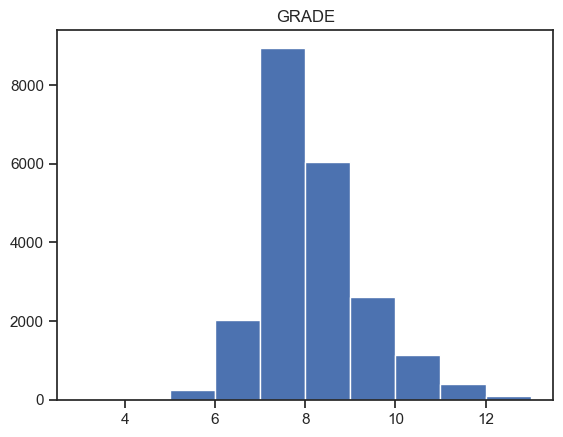

In [ ]:
plt.hist(df_num['GRADE'])
plt.title('GRADE')
plt.show()

# Procesamiento

Normalize Numerical Data

In [ ]:
# Use StandardScaler to transform numerical into a similar scale and decrease differences in magnitudes' impact in the analysis.
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
standard_scaler = StandardScaler()
df_num_ss = standard_scaler.fit_transform (df_num)
df_num_final = pd.DataFrame (df_num_ss, columns = df_num.columns)

In [ ]:
df_num_final.shape

(21535, 15)

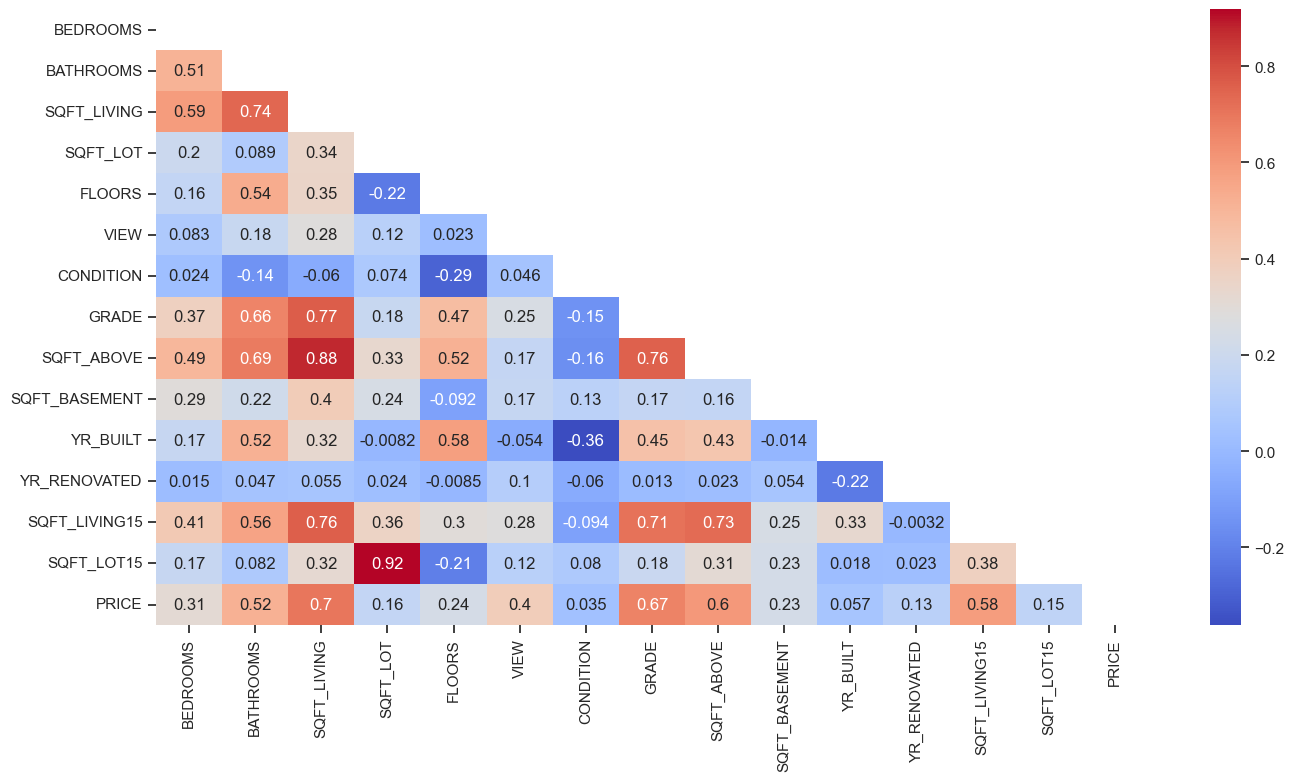

In [ ]:
# Check for correlations

df_num_corr = df_num_final.corr()
mask = np.zeros_like(df_num_corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(df_num_corr, mask=mask, annot=True, cmap = 'coolwarm')
plt.show()

Eliminaré las columnas que tengan coeficiente de correlación superior a 0,7.

In [ ]:
df_num_final = df_num_final.drop('SQFT_LOT', axis = 1)

In [ ]:
df_num_final = df_num_final.drop('SQFT_LIVING', axis = 1)

In [ ]:
df_num_final = df_num_final.drop('SQFT_ABOVE', axis = 1)

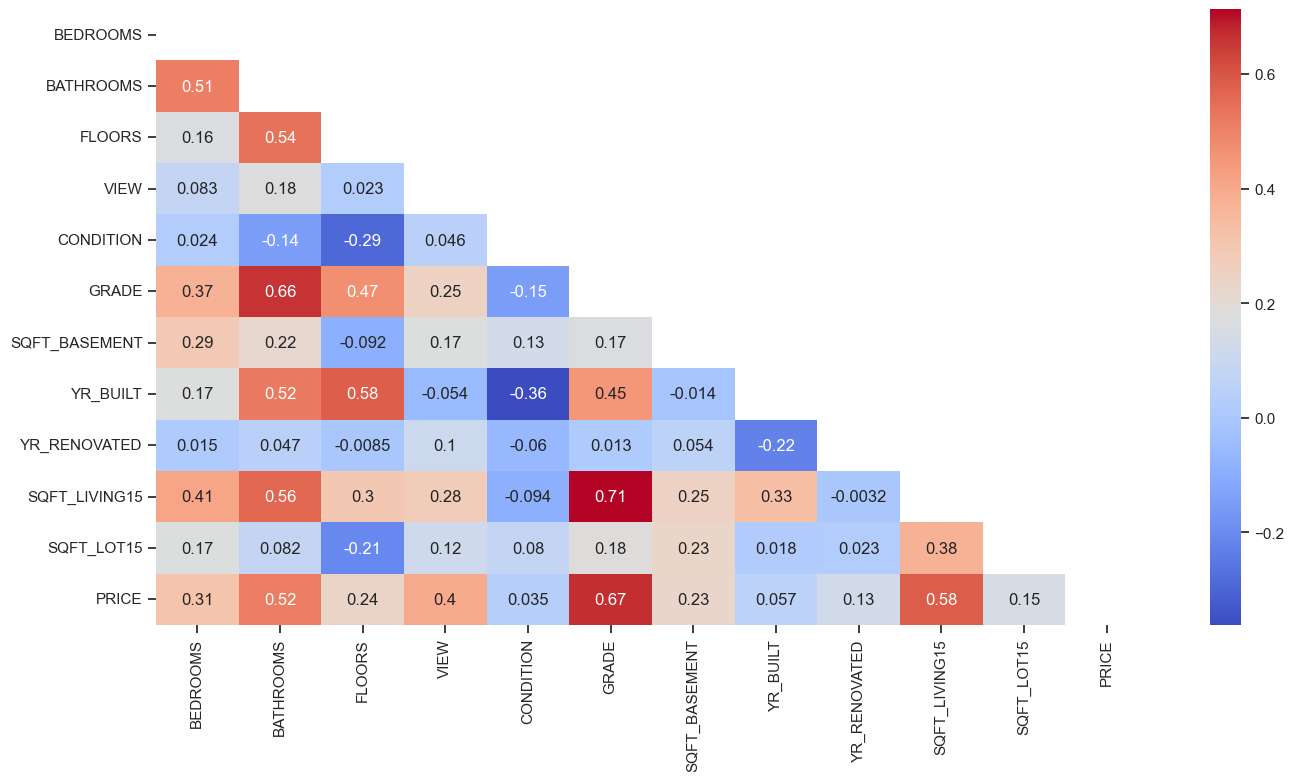

In [ ]:
# Check for correlations

df_num_corr = df_num_final.corr()
mask = np.zeros_like(df_num_corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(df_num_corr, mask=mask, annot=True, cmap = 'coolwarm')
plt.show()

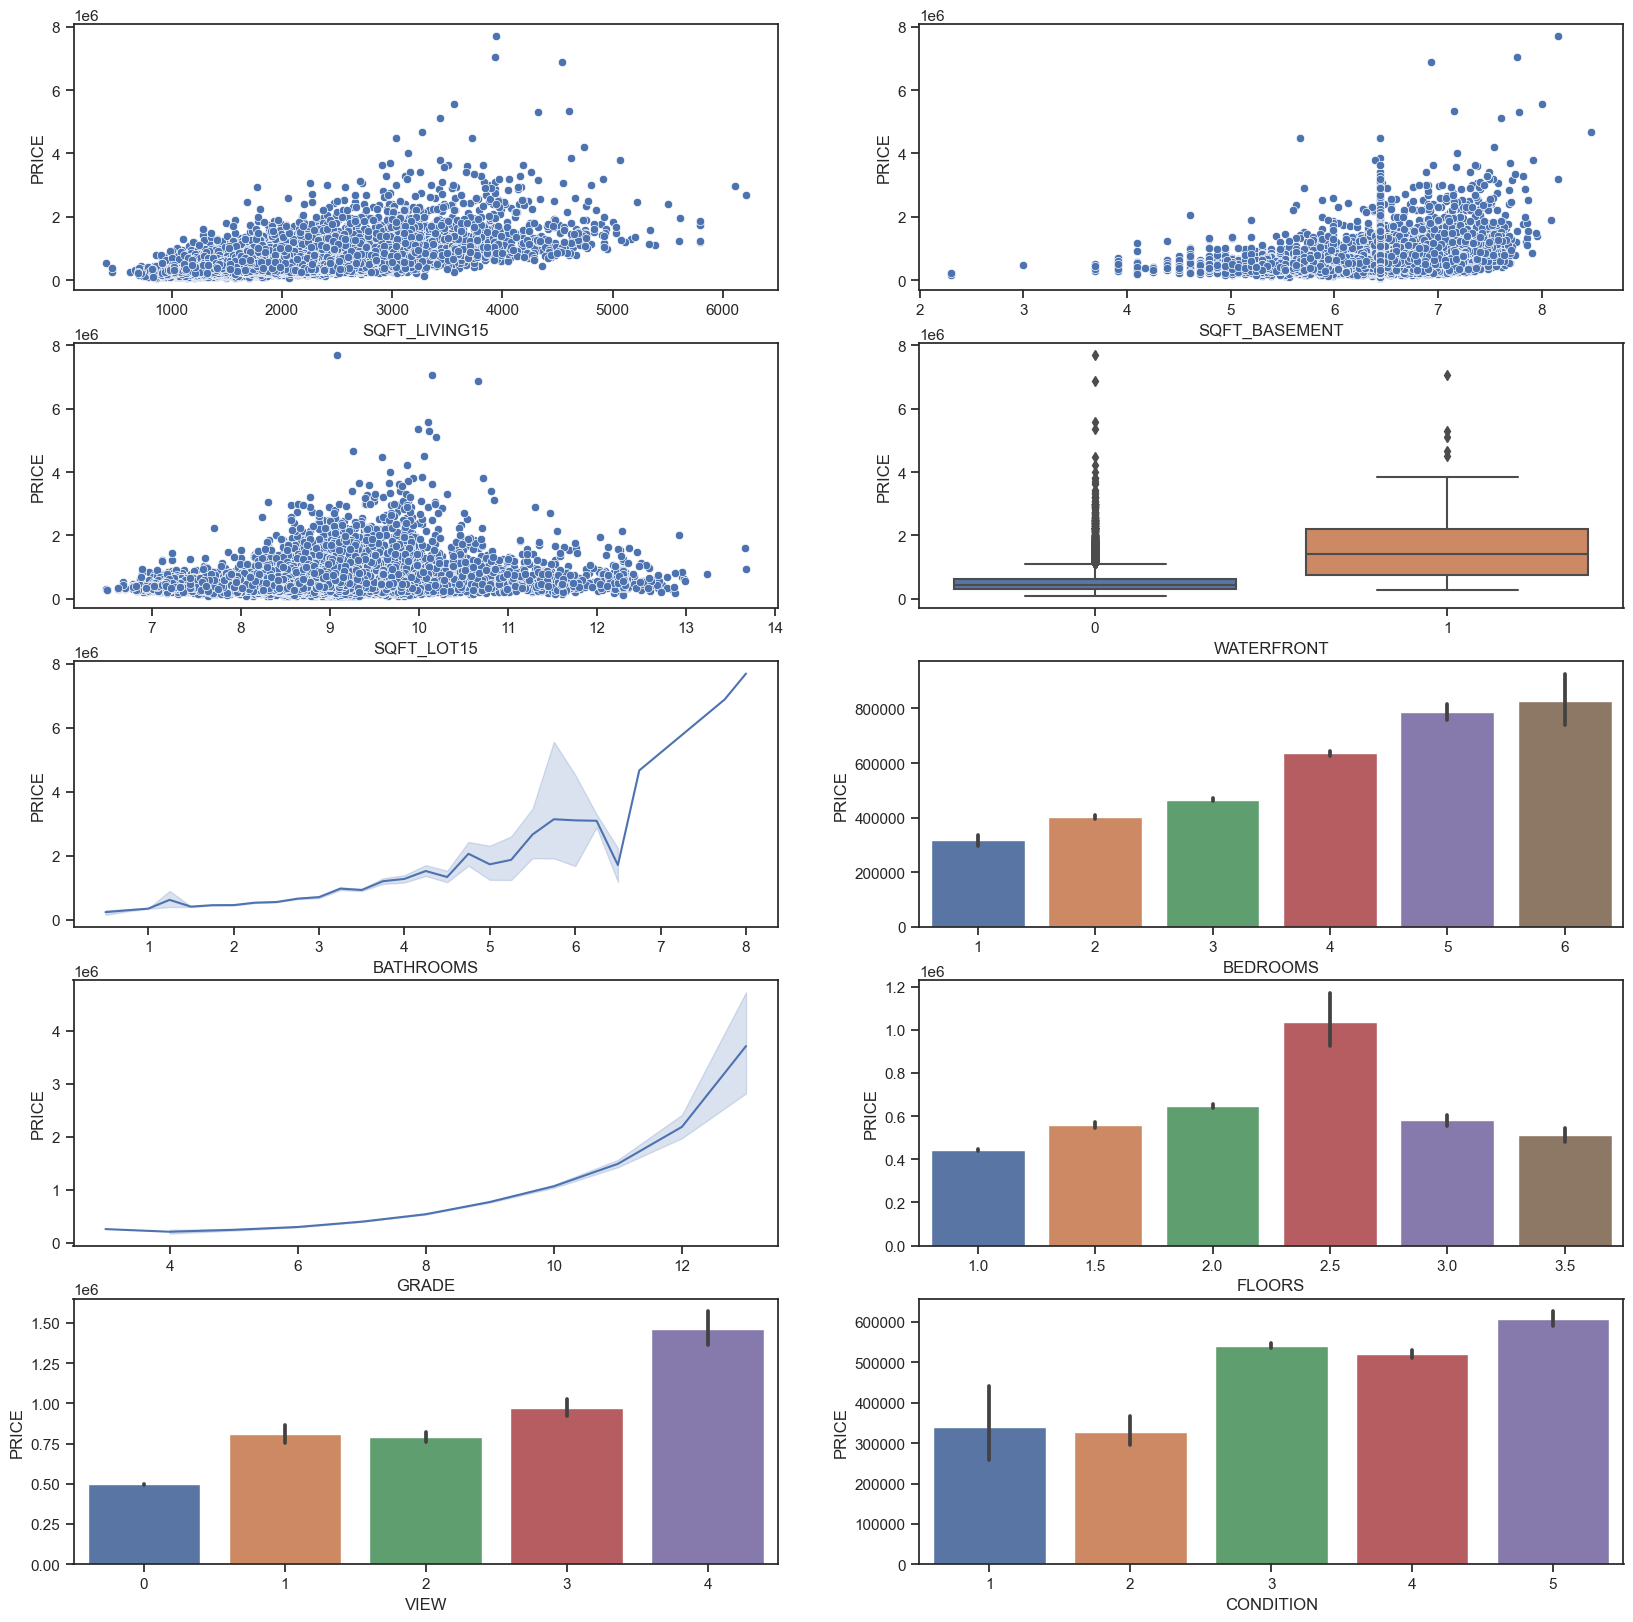

In [ ]:
# visualizing the relation between price and sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15, age, renovated, bedrooms, bathrooms, floors, waterfront, view, condition, grade
Fig, ax = plt.subplots(5, 2, figsize=(20, 20))
sns.scatterplot(x=df_num['SQFT_LIVING15'], y=df_num['PRICE'], ax=ax[0, 0])
sns.scatterplot(x=df_num['SQFT_BASEMENT'], y=df_num['PRICE'], ax=ax[0, 1])
sns.scatterplot(x=df_num['SQFT_LOT15'], y=df_num['PRICE'], ax=ax[1, 0])
sns.boxplot(x=df['WATERFRONT'], y=df['PRICE'], ax=ax[1, 1])
sns.lineplot(x=df['BATHROOMS'], y=df['PRICE'], ax=ax[2, 0])
sns.barplot(x=df['BEDROOMS'], y=df['PRICE'], ax=ax[2, 1])
sns.lineplot(x=df['GRADE'], y=df['PRICE'], ax=ax[3, 0])
sns.barplot(x=df['FLOORS'], y=df['PRICE'], ax=ax[3, 1])
sns.barplot(x=df['VIEW'], y=df['PRICE'], ax=ax[4, 0])
sns.barplot(x=df['CONDITION'], y=df['PRICE'], ax=ax[4, 1])
plt.show()

Categorical

In [ ]:
# Categorical variables will be processed using dummy variables.
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df_num_final.shape

(21535, 12)

In [ ]:
df_cat.shape

(21535, 2)

In [ ]:
# Create an instance of the OneHotEncoder with drop='first' to drop the first column of each dummy variable, thus preventing multilinearity.
encoder = OneHotEncoder(handle_unknown='error', drop='first')

# Fit the encoder to the categorical data
encoder.fit(df_cat)

# Transform the categorical data into dummy variables
df_cat_encoded = encoder.transform(df_cat).toarray() # Note data is converted to array, it should be converted to DataFrame afterwards.

# Get the feature names of the encoded variables
feature_names = encoder.get_feature_names_out(df_cat.columns)

# Convert the encoded array to a DataFrame with column names
df_cat_encoded = pd.DataFrame(df_cat_encoded, columns = feature_names)

In [ ]:
# Set DataFrame: concatenate dataframe with normalized numerical variables and dataframe with categorical variables (df_tt --> DataFrame to be used for Train-Test)
df_train_test = pd.concat([df_num_final, df_cat], axis=1)

In [ ]:
df_num_final.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)

df_train_test = pd.concat([df_num_final, df_cat], axis=1)

In [ ]:
# Drop the original categorical columns from the original DataFrame
df_train_test = df_train_test.drop(df_cat.columns, axis=1)

# Concatenate the encoded DataFrame with the original DataFrame
df_train_test = pd.concat([df_train_test, df_cat_encoded], axis=1)

# Visualization of code
df_train_test.shape

(21535, 82)

In [ ]:
# Check if dataframe has null values
df_train_test.isnull().values.any()
# If answer is True --> there are null values in dataframe
# If answer is False --> there are nor null values in dataframe

False

# Multiple Regression using Ordinary Leasts Squares (OLS) method.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Y = PRICE (Dependant variable). X = (Independant variables)
Y = df_train_test['PRICE']
X = df_train_test.drop(['PRICE'], axis=1)
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
print (model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     877.4
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:53:24   Log-Likelihood:                -14819.
No. Observations:               21535   AIC:                         2.980e+04
Df Residuals:                   21453   BIC:                         3.046e+04
Df Model:                          81                                         
Covariance Type:            nonrobust  

In [ ]:
# Datos del modelo
r2 = model.rsquared
adj_r2 = model.rsquared_adj
mse = model.mse_model
rmse = mse**0.5

In [ ]:
OLS = {'Res': ['OLS'], 'MSE': [mse], 'RMSE': [rmse], 'R2': [r2], 'ADJ_R2': [adj_r2]}

In [ ]:
OLS

{'Res': ['OLS'],
 'MSE': [204.2200485206536],
 'RMSE': [14.290558019918382],
 'R2': [0.7681367044426719],
 'ADJ_R2': [0.7672612591930498]}

In [ ]:
df_resultados = pd.DataFrame (OLS)

# Train-Test Split

In [ ]:
# test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
lm=linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
prediction = lm.predict(X_test)

In [ ]:
# df_pred --> DataFrame containing train-test results for Independent Variable Total Claim Amount
df_prediction = pd.DataFrame(columns=[y_test, prediction]).T
df_prediction

,
PRICE,
-0.610868,-0.967992
-0.024888,-0.282663
-0.134553,0.120256
0.125715,0.256859
-0.723272,-0.686990
...,...
0.511219,0.865013
-0.282281,-0.244040
-0.271328,-0.164657


In [ ]:
import math
from sklearn.metrics import mean_squared_error

### Model Performance

Proportion of variance in the dependent variable (Y = PRICE) that can be explained by the independent variable (X)

R2 es un número entre 0 y 1 que indica qué tan bien el modelo se ajusta a los datos observados.

In [ ]:
r2 = r2_score(y_test, prediction)
print('R-squared: ', round(r2,4))

R-squared:  0.7404


### Overfitting

El R2 ajustado tiene en cuenta la cantidad de variables independientes que se utilizan en el modelo y penaliza el uso excesivo de ellas.

Es una herramienta valiosa para evitar el sobreajuste y asegurar que el modelo sea más efectivo para hacer predicciones en datos nuevos y no vistos.

In [ ]:
n = len(X_test)
p = X_test.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
print ('Adjusted R2: ', round(adj_r2,3))

Adjusted R2:  0.735


### Mean Squared Error

In [ ]:
mse = mean_squared_error(y_test, prediction)
print('Mean Squared Error: ', round(mse, 3))

Mean Squared Error:  0.293


### Root Mean Squared Error

El RMSE es similar al MSE en el sentido de que mide la diferencia entre los valores predichos y los valores reales, pero a diferencia del MSE, el RMSE está en las mismas unidades que la variable dependiente.

In [ ]:
# Value is in the same units as dependant variable.
rmse = math.sqrt(mse) 
print('Root Mean Square Error: ', round (rmse,3))

Root Mean Square Error:  0.542


In [ ]:
# Creo un dataframe para almacenar los resultados y compararlos fácilmente.
resultados_1 = {'Res': 'TT1','MSE': mse, 'RMSE': rmse, 'R2': r2, 'ADJ_R2': adj_r2}
df_resultados = df_resultados.append(resultados_1, ignore_index=True)
df_resultados.head ()

/var/folders/23/k5r960jx4j5_kg5518sbq1hc0000gp/T/ipykernel_55416/1838565868.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(resultados_1, ignore_index=True)


,Res,MSE,RMSE,R2,ADJ_R2
0,OLS,204.220049,14.290558,0.768137,0.767261
1,TT1,0.293398,0.541662,0.740384,0.735345


# Análisis de los resultados:


Los valores de R2 y R2-Adj son aceptables.

Adjusted R-squared implies a 73,5% of the model is explained by independent variables considered as a whole. 

# OLS 2

In [ ]:
# Y = PRICE (Dependant variable). X = Independant variables, except those with p-value above 0.05 
Y2 = df_train_test['PRICE']
X2 = df_train_test.drop(['PRICE', 'ZIPCODE_98022', 'ZIPCODE_98042', 'ZIPCODE_98030', 'ZIPCODE_98031', 'ZIPCODE_98032', 'ZIPCODE_98198'], axis=1)
X2 = sm.add_constant(X2)
model2 = sm.OLS(Y2,X2).fit()
print (model2.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     947.7
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:53:24   Log-Likelihood:                -14820.
No. Observations:               21535   AIC:                         2.979e+04
Df Residuals:                   21459   BIC:                         3.040e+04
Df Model:                          75                                         
Covariance Type:            nonrobust  

# Train test split 2

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=42)
lm2 = linear_model.LinearRegression()
model2 = lm.fit(X_train2, y_train2)
prediction2 = lm.predict(X_test2)

In [ ]:
# df_pred --> DataFrame containing train-test results for Independent Variable Total Claim Amount
df_prediction2 = pd.DataFrame(columns=[y_test2, prediction2]).T
df_prediction2

,
PRICE,
-0.610868,-0.967285
-0.024888,-0.282954
-0.134553,0.120905
0.125715,0.257087
-0.723272,-0.686424
...,...
0.511219,0.865890
-0.282281,-0.243637
-0.271328,-0.164661


In [ ]:
r2_train_test_2 = r2_score(y_test2, prediction2)
print('R2:', round(r2_train_test_2, 4))

R2: 0.7403


In [ ]:
n = len(X_test2)
p = X_test2.shape[1]
adj_r2_2 = 1-((1-r2_train_test_2)*(n-1)/(n-p-1))
print ('Adjusted R2: ', round(adj_r2_2,3))

Adjusted R2:  0.736


In [ ]:
mse2 = mean_squared_error(y_test2, prediction2)
print('Mean Squared Error: ', round(mse2, 3))

Mean Squared Error:  0.293


In [ ]:
# Value is in the same units as dependant variable.
rmse2 = math.sqrt(mse2) 
print('Root Mean Square Error: ', round (rmse2,3))

Root Mean Square Error:  0.542


In [ ]:
resultados_2 = {'Res': 'TT2','MSE': mse2, 'RMSE': rmse2, 'R2': r2_train_test_2, 'ADJ_R2': adj_r2_2}
df_resultados = df_resultados.append(resultados_2, ignore_index=True)
df_resultados.head ()

/var/folders/23/k5r960jx4j5_kg5518sbq1hc0000gp/T/ipykernel_55416/209394266.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(resultados_2, ignore_index=True)


,Res,MSE,RMSE,R2,ADJ_R2
0,OLS,204.220049,14.290558,0.768137,0.767261
1,TT1,0.293398,0.541662,0.740384,0.735345
2,TT2,0.293458,0.541717,0.740332,0.735666


### Conclusiones Train Test 2: 

Los resultados se mantienen prácticamente iguales. El ajuste del modelo mediante la eliminación de variables correlacionadas genera una leve disminución del R2.

# OLS 3

In [ ]:
# Y = PRICE (Dependant variable). X = Independant variables, except those with p-value above 0.05 in OLS and FLOORS (0.206)  
Y3 = df_train_test['PRICE']
X3 = df_train_test.drop(['PRICE', 'ZIPCODE_98022', 'ZIPCODE_98042', 'ZIPCODE_98030', 'ZIPCODE_98031', 'ZIPCODE_98032', 'ZIPCODE_98198', 'FLOORS'], axis=1)
X3 = sm.add_constant(X3)
model3 = sm.OLS(Y3,X3).fit()
print (model3.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     960.3
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:53:25   Log-Likelihood:                -14823.
No. Observations:               21535   AIC:                         2.980e+04
Df Residuals:                   21460   BIC:                         3.039e+04
Df Model:                          74                                         
Covariance Type:            nonrobust  

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y3, test_size=0.2, random_state=42)
lm3 = linear_model.LinearRegression()
model3 = lm.fit(X_train3, y_train3)
prediction3 = lm.predict(X_test3)

In [ ]:
# df_pred --> DataFrame containing train-test results for Independent Variable Total Claim Amount
df_prediction3 = pd.DataFrame(columns=[y_test3, prediction3]).T
df_prediction3

,
PRICE,
-0.610868,-0.968241
-0.024888,-0.284543
-0.134553,0.119013
0.125715,0.259136
-0.723272,-0.686245
...,...
0.511219,0.865840
-0.282281,-0.244633
-0.271328,-0.165910


In [ ]:
r2_train_test_3 = r2_score(y_test3, prediction3)
print('R2:', round(r2_train_test_3, 4))

R2: 0.7402


In [ ]:
n = len(X_test3)
p = X_test3.shape[1]
adj_r2_3 = 1-((1-r2_train_test_3)*(n-1)/(n-p-1))
print ('Adjusted R2: ', round(adj_r2_3,3))

Adjusted R2:  0.736


In [ ]:
mse3 = mean_squared_error(y_test3, prediction3)
print('Mean Squared Error: ', round(mse3, 3))

Mean Squared Error:  0.294


In [ ]:
# Value is in the same units as dependant variable.
rmse3 = math.sqrt(mse3) 
print('Root Mean Square Error: ', round (rmse3,3))

Root Mean Square Error:  0.542


In [ ]:
resultados_3 = {'Res': 'TT3','MSE': mse3, 'RMSE': rmse3, 'R2': r2_train_test_3, 'ADJ_R2': adj_r2_3}
df_resultados = df_resultados.append(resultados_3, ignore_index=True)
df_resultados.head ()

/var/folders/23/k5r960jx4j5_kg5518sbq1hc0000gp/T/ipykernel_55416/2235871583.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(resultados_3, ignore_index=True)


,Res,MSE,RMSE,R2,ADJ_R2
0,OLS,204.220049,14.290558,0.768137,0.767261
1,TT1,0.293398,0.541662,0.740384,0.735345
2,TT2,0.293458,0.541717,0.740332,0.735666
3,TT3,0.293574,0.541825,0.740229,0.735624


In [ ]:
df_resultados.to_csv('df_resultados.csv', index=False)

CONCLUSIONS: The elimination of variables that do not explain the model has not significantly improved the test's effectiveness.

# Resultados

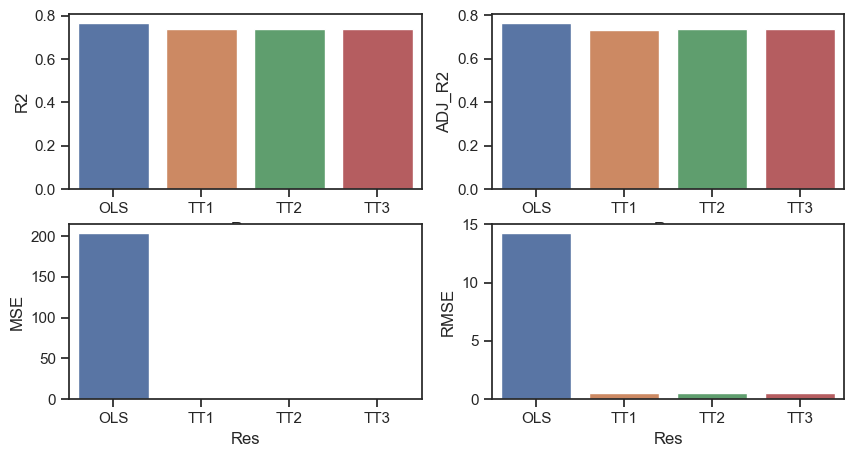

In [ ]:
Fig, ax = plt.subplots(2, 2, figsize=(10, 5))

sns.barplot(x = 'Res', y='R2', data = df_resultados, ax=ax[0, 0])
sns.barplot(x = 'Res', y='ADJ_R2', data = df_resultados, ax=ax[0, 1])
sns.barplot(x = 'Res', y='MSE', data = df_resultados, ax=ax[1, 0])
sns.barplot(x = 'Res', y='RMSE', data = df_resultados, ax=ax[1, 1])
plt.xlabel('Res')
plt.ylabel('R2')
plt.ylabel('ADJ_R2')
plt.ylabel('MSE')
plt.ylabel('RMSE')
plt.show()

# Propiedades con Precio > 650.000

In [ ]:
df_num.columns

Index(['BEDROOMS', 'BATHROOMS', 'SQFT_LIVING', 'SQFT_LOT', 'FLOORS', 'VIEW',
       'CONDITION', 'GRADE', 'SQFT_ABOVE', 'SQFT_BASEMENT', 'YR_BUILT',
       'YR_RENOVATED', 'SQFT_LIVING15', 'SQFT_LOT15', 'PRICE'],
      dtype='object')

In [ ]:
df_cat.columns

Index(['WATERFRONT', 'ZIPCODE'], dtype='object')

All rows from df_num and df_cat were preserved in their order. I will concatenate them.

In [ ]:
df_num.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)
df_concatenated = pd.concat([df_num, df_cat], axis=1)

In [ ]:
# I filter the properties with Price > 650,000.
df_filtered = df_concatenated [df_concatenated ['PRICE'] > 650000]

In [ ]:
df_filtered.shape

(5171, 17)

In [ ]:
df_num2 = df_filtered.loc[:, ['BEDROOMS', 'BATHROOMS', 'SQFT_LIVING', 'SQFT_LOT', 'FLOORS', 'VIEW',
       'CONDITION', 'GRADE', 'SQFT_ABOVE', 'SQFT_BASEMENT', 'YR_BUILT',
       'YR_RENOVATED', 'SQFT_LIVING15', 'SQFT_LOT15', 'PRICE']]

df_num2.shape

(5171, 15)

In [ ]:
df_cat2 = df_filtered.loc[: ,['WATERFRONT', 'ZIPCODE']]
df_cat2.shape

(5171, 2)

In [ ]:
standard_scaler = StandardScaler()
df_num2_ss = standard_scaler.fit_transform (df_num2)
df_num2_final = pd.DataFrame (df_num2_ss, columns = df_num2.columns)

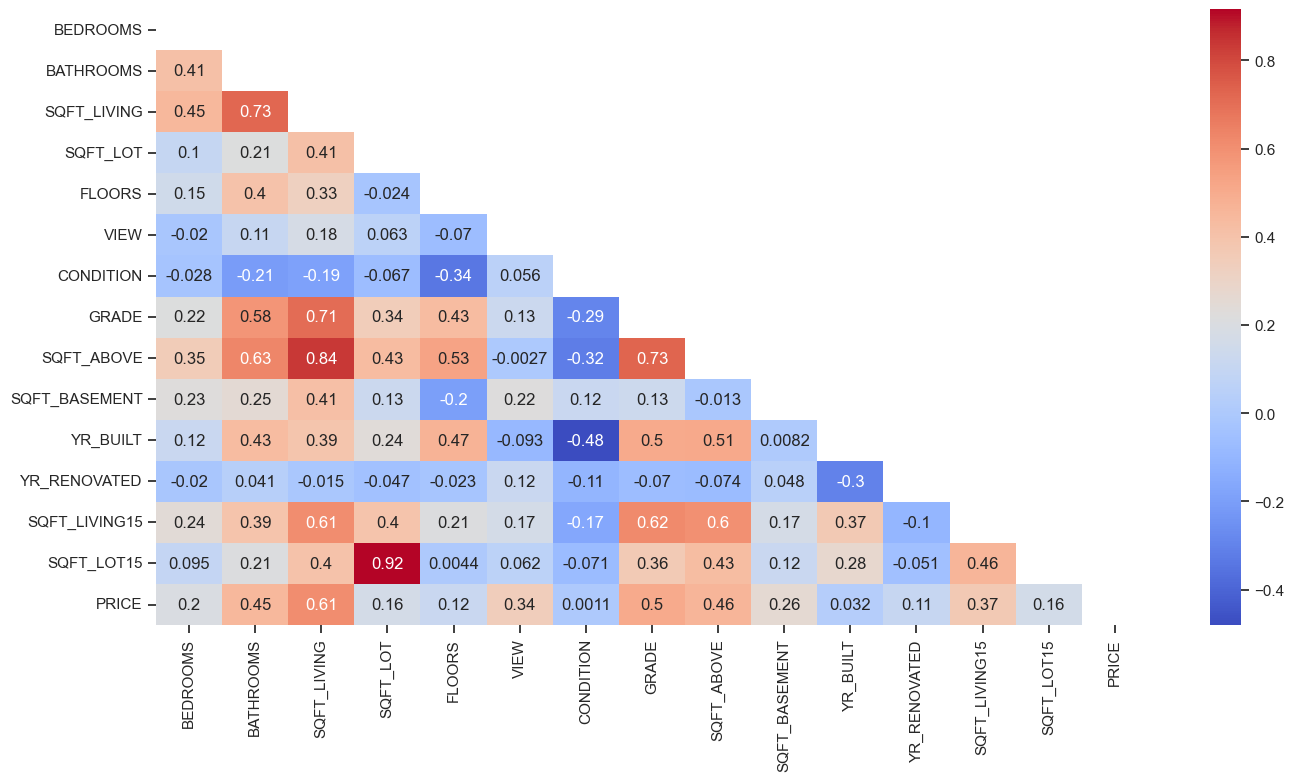

In [ ]:
# Check for correlations

df_num2_corr = df_num2_final.corr()
mask = np.zeros_like(df_num2_corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(df_num2_corr, mask=mask, annot=True, cmap = 'coolwarm')

<Axes: >

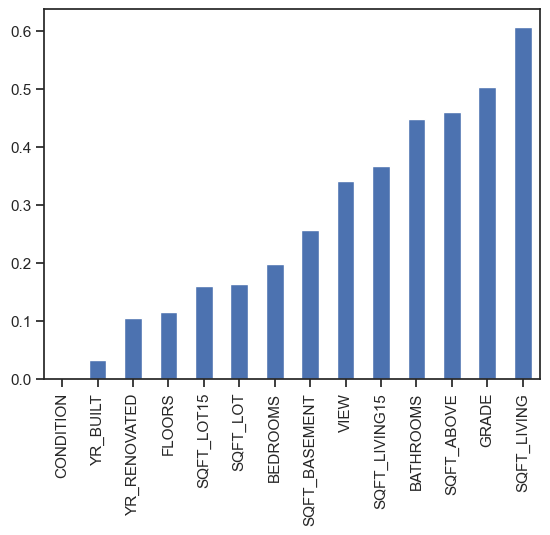

In [ ]:
# Relationship of the numeric variables with the Price variable.
df_num2.corr()['PRICE'][:-1].sort_values().plot(kind='bar')

In [ ]:
# Create an instance of the OneHotEncoder with drop='first' to drop the first column of each dummy variable, thus preventing multilinearity.
encoder = OneHotEncoder(handle_unknown='error', drop='first')

# Fit the encoder to the categorical data
encoder.fit(df_cat2)

# Transform the categorical data into dummy variables
df_cat2_encoded = encoder.transform(df_cat2).toarray() # Note data is converted to array, it should be converted to DataFrame afterwards.

# Get the feature names of the encoded variables
feature_names = encoder.get_feature_names_out(df_cat2.columns)

# Convert the encoded array to a DataFrame with column names
df_cat2_encoded = pd.DataFrame(df_cat2_encoded, columns = feature_names)

In [ ]:
# Set DataFrame: concatenate dataframe with normalized numerical variables and dataframe with categorical variables (df_tt --> DataFrame to be used for Train-Test)
df_train_test2 = pd.concat([df_num2_final, df_cat2], axis=1)

In [ ]:
df_num2_final.reset_index(drop=True, inplace=True)
df_cat2.reset_index(drop=True, inplace=True)
df_train_test2 = pd.concat([df_num2_final, df_cat2], axis=1)

In [ ]:
# Drop the original categorical columns from the original DataFrame
df_train_test2 = df_train_test2.drop(df_cat2.columns, axis=1)

# Concatenate the encoded DataFrame with the original DataFrame
df_train_test2 = pd.concat([df_train_test2, df_cat2_encoded], axis=1)

# Visualization of code
df_train_test2.shape

(5171, 78)

# OLS

In [ ]:
# Y = PRICE (Dependant variable). X = (Independant variables)
Y_650 = df_train_test2['PRICE']
X_650 = df_train_test2.drop(['PRICE'], axis=1)
X_650 = sm.add_constant(X_650)
model_650 = sm.OLS(Y_650,X_650).fit()
print (model_650.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     186.0
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:53:26   Log-Likelihood:                -3877.4
No. Observations:                5171   AIC:                             7911.
Df Residuals:                    5093   BIC:                             8422.
Df Model:                          77                                         
Covariance Type:            nonrobust  

In [ ]:
# Datos del modelo
r2_650 = model_650.rsquared
adj_r2_650 = model_650.rsquared_adj
mse_650 = model_650.mse_model
rmse_650 = mse**0.5

In [ ]:
OLS_650 = {'Res': ['OLS_650'], 'MSE_650': [mse_650], 'RMSE_650': [rmse_650], 'R2_650': [r2_650], 'ADJ_R2_650': [adj_r2_650]}

In [ ]:
OLS_650

{'Res': ['OLS_650'],
 'MSE_650': [49.53969797554382],
 'RMSE_650': [0.5416622193634953],
 'R2_650': [0.737682603774294],
 'ADJ_R2_650': [0.7337166820171019]}